<a href="https://colab.research.google.com/github/sverdoot/DL-in-NLP-course/blob/master/workshop%201/task4_one_matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word2vec only with one matrix

Choose CBOW/Skip-Gram again. Implement it, but now without second `h_dim x vocab_size` matrix. Remember what was the loss function in Stanford lecture.

$$ L = - \frac{1}{T} \sum_{t=1}^T \sum_{-m <= j <= m, j \ne 0} log P(w_{t+j}|w_{t+j-m})$$


$$ P(w_h | w_i) = \frac{exp(s(v_i, v_h))}{\sum exp(s(v_i, v_w))}$$

Where $s(x, y)$ is a similarity function. It is common to use dot-product here $s(x, y) = x^Ty$. The sum in the denominator is across all vocabulary for $P$ to be a probability distribution.

Look to this formula closer. There is no projection back to vocabulary dimension in the loss! So, we can reduce the number of parameters by the factor of two by not using the second matrix $W'$. Your new task is to code CBOW / SkipGram with this loss.

**Main idea:**

We project word vectors to some space. Next, we work with the space itself. We update projection matrix weights so that similar (in the terms of Distributional semantics) words have similar vectors in that space. We don't need to solve classification task explicitly here.

**Tip:**

Work with matrix operations and not with nn.layers / keras.layers.

**Results of this task** (the very same as in task 3):
 * trained word vectors (mention somewhere, how long it took to train)
 * plotted loss (so we can see that it has converged)
 * function to map token to corresponding word vector
 * beautiful visualizations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task)
 * qualitative evaluations of word vectors: nearest neighbors, word analogies


**Extra:**
 * quantitative evaluation:
   * for intrinsic evaluation you can find datasets [here](https://aclweb.org/aclwiki/Analogy_(State_of_the_art))
   * for extrincis evaluation you can use [these](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)



Supplementary materials:
  * [cs224n winter 2017 lecture 2 video](https://www.youtube.com/watch?v=ERibwqs9p38&list=PL3FW7Lu3i5Jsnh1rnUwq_TcylNr7EkRe6&index=2)
  * [cs224n winter 2019 lecture 1 slides](http://web.stanford.edu/class/cs224n/slides/cs224n-2019-lecture01-wordvecs1.pdf)

In [0]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(42)
import numpy as np

import collections, math, os, random, zipfile
import numpy as np

from six.moves import urllib
from six.moves import xrange

url = 'http://mattmahoney.net/dc/'

UNK_TOKEN = '<UNK>'

import requests, os
from os.path import isfile

In [0]:
def one_hot(batch, voc_size, batch_size=2):  
  if batch_size != 1:
    batch_onehot = torch.zeros(len(batch), voc_size)
    for i, e in enumerate(batch):
      for y in e:
        batch_onehot[i, int(y)] = batch_onehot[i, int(y)] + 1
  else:
    batch_onehot = torch.zeros(voc_size)
    for i in batch:
      batch_onehot[int(i)] = 1
      
  return batch_onehot

if not os.path.isfile('text8'):
    with open('data.zip', 'wb') as f:
        r = requests.get('http://mattmahoney.net/dc/text8.zip')
        f.write(r.content)
    !unzip 'data.zip' 

def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = (f.read(f.namelist()[0]).split())
        data = list(map(lambda x: x.decode(), data))
    return data

!ls
#words = read_data('text8')
with open('text8') as f:
    words = f.read().split()

data.zip  sample_data  text8


In [0]:
VOCAB_SIZE = 10000

full_data = words
freq_dict = collections.Counter(full_data)
no_rare_dict = freq_dict.most_common(VOCAB_SIZE)
min_freq = no_rare_dict[-1][1]
vocabulary = [x[0] for x in no_rare_dict]
vocabulary.append(UNK_TOKEN)

data = []
for i, word in enumerate(full_data):
  if freq_dict[word] > min_freq:
    data.append(word)
  else:
    data.append(UNK_TOKEN)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

data_idx = 0

class Batcher:
  
  def __init__(self, batch_size, window_size, data, data_idx=0):
    self.batch_size = batch_size
    self.window_size = window_size
    self.data = data
    
  def __iter__(self):
  
    return self

  def __next__(self, data_idx_=None):
    window_size = self.window_size
    batch_size = self.batch_size
    data = self.data
    global data_idx
    batch = []
    labels = [] 
  
    context = collections.deque(maxlen=2 * window_size + 1)
  
    for _ in range(2 * window_size + 1):
      context.append(word2idx[data[data_idx]])
      data_idx = (data_idx + 1) % len(data)
  
    for i in range(batch_size):
      batch.append([context[j] for  j in list(range(window_size)) + list(range(window_size + 1, 2 * window_size + 1))])
      labels.append(context[window_size])
      context.append(word2idx[data[data_idx]])
      data_idx = (data_idx + 1) % len(data)
    
    return (batch, labels)

In [0]:
class ShortCBOW(nn.Module):
    def __init__(self, vocab_size, output_size):
        super(ShortCBOW, self).__init__()
        self.W = nn.Linear(vocab_size, output_size)
        self.vocab_size = vocab_size
        nn.init.normal_(self.W.weight, std = 0.1)

    def forward(self, inputs):
        out = self.W(inputs)
        similarity_vec = torch.matmul(out.to(device=device, dtype=dtype), self.W.weight.to(device=device, dtype=dtype))
        #return F.log_softmax(similarity_vec, dim=1)
        #return F.softmax(similarity_vec, dim=1)
        return similarity_vec

In [0]:
part_data = data[:300000]
vocab_size = len(vocabulary)
batch_size = 1000
output_size = 40
window_size = 2
print_every = 100

USE_GPU = True

dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('using device:', device)

model = ShortCBOW(vocab_size=vocab_size, output_size=output_size)
model = model.to(device=device)
data_idx = 0
batcher = Batcher(batch_size, window_size, part_data)
build_batch = iter(batcher)

loss_function = nn.CrossEntropyLoss()

losses = []
it_per_ep = len(part_data) // batch_size

using device: cuda


In [0]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)

In [0]:
start_time = time.clock()
for e in range(30000):
    batch, label = next(build_batch)
    one_hot_vector = one_hot(batch, vocab_size)
    model.train() 
    x = one_hot_vector.to(device=device, dtype=dtype) / window_size 
    scores = model(x).to(device=device, dtype=dtype)
    loss = loss_function(scores, torch.tensor(label, device=device, dtype=torch.long))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if e % it_per_ep == 0:
        print('Iteration %d, loss = %.4lg' % (e, sum(losses[-it_per_ep:])))
        print('Time %lg' % (time.clock() - start_time))
        print()

trained about 10 mins

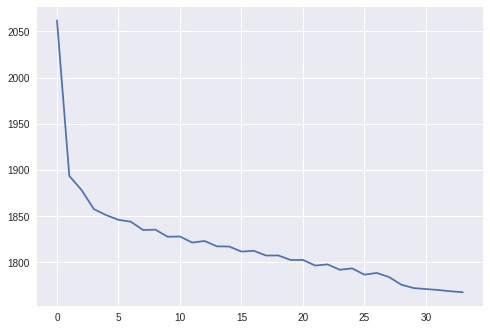

In [0]:
import matplotlib.pyplot as plt
loss_ep = [sum(losses[i * it_per_ep : i * it_per_ep + it_per_ep]) for i in range(len(losses) // it_per_ep)]
plt.plot(loss_ep)

In [0]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)
    

In [0]:
word2vec = lambda x: model.W(one_hot([word2idx[x]], vocab_size, batch_size=1).to(device=device, dtype=dtype)).to(device=device, dtype=torch.float).detach().cpu().numpy()
idx2vec = lambda x: model.W(one_hot([x], vocab_size, batch_size=1).to(device=device, dtype=dtype)).to(device=device, dtype=torch.float).detach().cpu().numpy()

In [0]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30,n_components=2, init='pca')
plot_only = 200
final_embeddings = []
final_embeddings = [idx2vec(i) for i in range(plot_only)]
low_dim_embs = tsne.fit_transform(np.array(final_embeddings))
labels = [idx2word[i] for i in range(plot_only)]

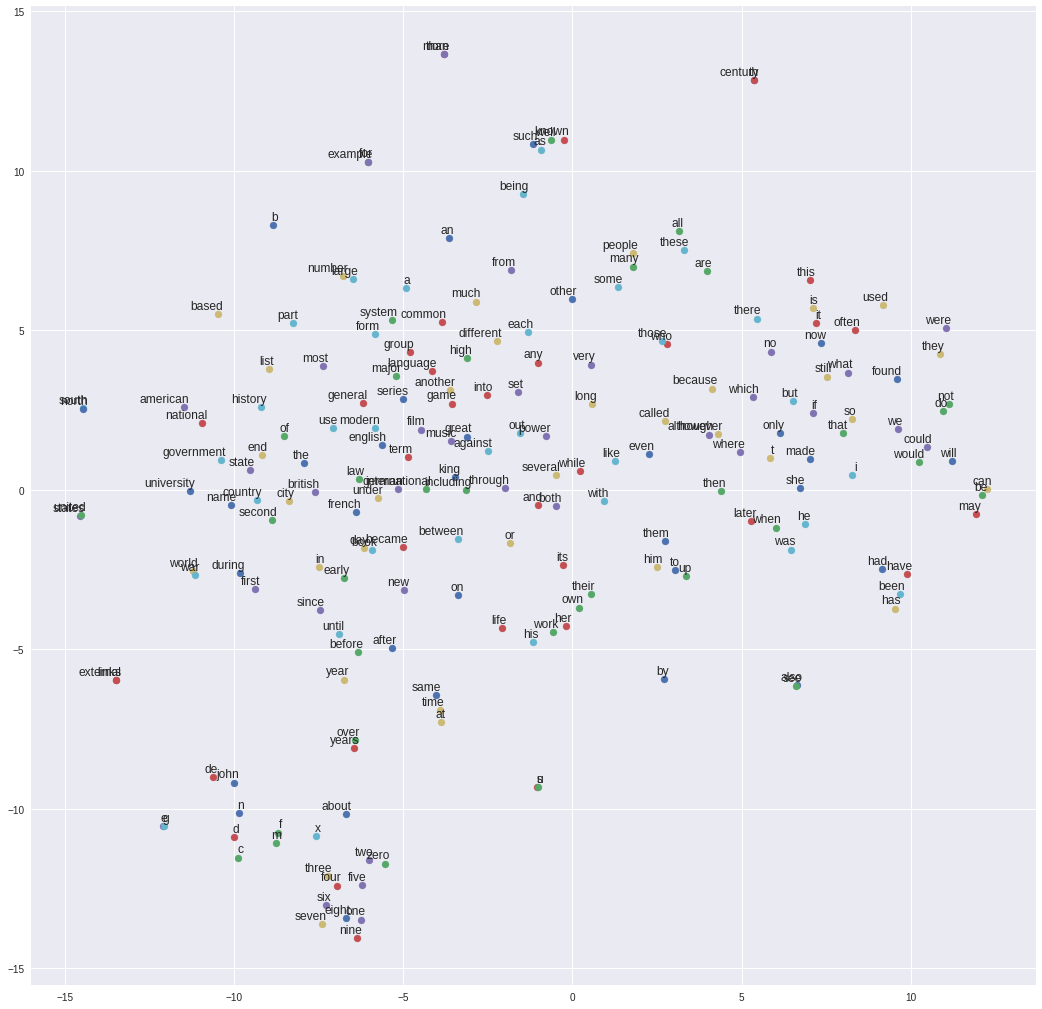

In [0]:
plot_with_labels(low_dim_embs, labels)

In [0]:
def cosine_similarity(word1, word2, word2vec):
  vec1 = word2vec(word1)
  vec2 = word2vec(word2)
  return np.dot(vec1, vec2) / np.linalg.norm(vec1) / np.linalg.norm(vec2)

In [0]:
def nearest_neighbours(words, vocabulary, word2vec, num_neighb=5):
  word_neighb = {}
  for word1 in words:
    similarity = {}
    for word2 in vocabulary:
      similarity[word2] = cosine_similarity(word1, word2, word2vec)
    f = lambda x: similarity[x]
    most_similar = list(similarity.keys())
    most_similar.sort(reverse=True, key=f)
    word_neighb[word1] = most_similar[:num_neighb]
  return word_neighb

In [0]:
nearest_neighbours(['american', 'he', 'year', 'world', 'north', 'may'], vocabulary, word2vec)

{'american': ['american', 'samoa', 'football', 'league', 'national'],
 'he': ['he', 'she', 'when', 'was', 'said'],
 'may': ['may', 'be', 'might', 'refer', 'must'],
 'north': ['north', 'south', 'east', 'central', 'america'],
 'world': ['world', 'war', 'ii', 'factbook', 'cia'],
 'year': ['year', 'per', 'before', 'rate', 'period']}

In [0]:
nearest_neighbours(['book', 'state'], vocabulary, word2vec)

{'book': ['book', 'regularly', 'imprisoned', 'reduces', 'house'],
 'state': ['state', 'department', 'of', 'head', 'the']}

In [0]:
model.W.weight

Parameter containing:
tensor([[ 0.3839,  0.3669,  0.3054,  ...,  0.0523, -0.1931,  0.4047],
        [ 0.0548,  0.2310, -0.2747,  ...,  0.0242, -0.0698, -0.1363],
        [ 0.1720,  0.0778,  0.3935,  ..., -0.0894, -0.0666,  0.1419],
        ...,
        [ 0.1066,  0.1107,  0.1306,  ..., -0.0361, -0.0764, -0.0361],
        [-0.2518, -0.1702, -0.1119,  ...,  0.1098,  0.1558, -0.1634],
        [-0.0378, -0.0408,  0.0053,  ...,  0.0633, -0.0335,  0.0895]],
       device='cuda:0', requires_grad=True)

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

#torch.save(model.state_dict(), '/content/drive/My Drive/model_task4')

In [0]:
#model.load_state_dict(torch.load('/content/drive/My Drive/model_task4'))
#model.eval()